# Las Vegas Restaurants Reviews NLP and more EDA

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import seaborn as sns

%matplotlib inline

In [2]:
# For NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import unicodedata
import string
import re

from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

np.set_printoptions(linewidth=100) 

pt = string.punctuation
sw = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [3]:
from wordcloud import WordCloud, STOPWORDS 

In [4]:
# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Logisitc Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


## Data Processing

#### Import Data

In [6]:
raw_reviews = pd.read_pickle('../data/english_reviews.pkl')

In [7]:
reviews = raw_reviews.loc[raw_reviews.text.apply(lambda x : True if len(x.split(' ')) > 10 else False)]

In [8]:
reviews.reset_index(drop=True, inplace=True)

In [9]:
reviews[reviews.isna().any(axis=1)]

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,language


In [10]:
(reviews.stars.value_counts()/reviews.stars.value_counts().sum()).sort_index()

1    0.124113
2    0.084543
3    0.118845
4    0.228227
5    0.444272
Name: stars, dtype: float64

In [11]:
reviews.shape

(1527548, 10)

In [12]:
reviews.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,language
0,fnZrZlqW1Z8iWgTVDfv_MA,WUAt5-krh075Ie44np8Hew,YDkC5VVT8s9NlIZtAr8NUA,5,0,0,0,So why would I be giving a Fast Food chain loc...,2010-11-27 09:33:34,en
1,fnZrZlqW1Z8iWgTVDfv_MA,S9vIs-je49jqbhpWSQ8yHg,mxtalrN7VHVQwGjv8ln5yg,2,0,0,0,I come here bout 3x's a mo. & I just can't do ...,2016-03-19 09:03:09,en
2,fnZrZlqW1Z8iWgTVDfv_MA,i2Soid_X8XsSTyIrPOst6g,xammeA3ftpFoAN13v5Blyg,1,2,0,0,WORST experience EVER!!!!! never have i ate an...,2015-04-02 06:14:51,en
3,fnZrZlqW1Z8iWgTVDfv_MA,uDYGaAOUgo7SLuH5nUZs3w,gQhFacMGI41mfVXqw1E7bQ,4,0,0,0,Hot fresh food usually. Staff seems to turn o...,2014-08-14 23:00:34,en
4,fnZrZlqW1Z8iWgTVDfv_MA,Xg7HuBvuZHTBog1G_2Wk0w,0PXhJMztE3ijzQPjiwPERg,3,0,0,0,Beer battered cod fish seems really rubbery. I...,2015-03-23 02:10:52,en


In [13]:
# X is reviews' text and y is 5 stars or not
X = np.array(reviews.text)
y = np.array(reviews.stars.apply(lambda s: 1 if s == 5 else 0))

In [14]:
X.shape, y.shape

((1527548,), (1527548,))

In [15]:
# Baseline Accuracy/Model = 
y.sum()/len(y)

0.444272127618903

#### Split Data

In [16]:
final_X_train, final_X_test, final_y_train, final_y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [17]:
final_X_train.shape, final_y_train.shape

((1222038,), (1222038,))

In [18]:
sli = (len(final_X_train) // 2) + 1 ; sli

611020

In [19]:
X_half_1 = final_X_train[0:sli]
X_half_2 = final_X_train[sli:]

y_half_1 = final_y_train[0:sli]
y_half_2 = final_y_train[sli:]


In [20]:
y_half_1.sum(), y_half_2.sum()

(271420, 271497)

In [21]:
sli_t = sli + 160000

In [22]:
X_half_1_t = final_X_train[sli:sli_t]
y_half_1_t = final_y_train[sli:sli_t]

In [23]:
y_half_1_t.sum()

71078

##### Small Subsets

In [24]:
X_tiny = final_X_train[501000:521000]

y_tiny = final_y_train[501000:521000]

X_tiny_t = final_X_train[524000:529000]

y_tiny_t = final_y_train[524000:529000]

y_tiny.sum(), y_tiny_t.sum()

(8807, 2236)

In [25]:
X_small = final_X_train[30000:230000]

y_small = final_y_train[30000:230000]

X_small_t = final_X_train[231000:281000]

y_small_t = final_y_train[231000:281000]

y_small.sum(), y_small_t.sum()

(88435, 22059)

## NLP

### Tokenizer

In [26]:
for i, w in enumerate(sw):
    sw[i] = w.replace("'",'')

In [27]:
sw + ['u', 'a', 'aa', 'aaa', 'im', 'ive', 'isnt'];

In [28]:
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    
    doc = re.sub(r"[^a-z ]+", '', doc)
    
    doc = word_tokenize(doc)

    #tags = pos_tag(doc, tagset='universal')
    #doc = [word for word,pos in tags if (pos == 'ADJ')]
                            #pos == 'NOUN' or pos == 'VERB' or pos == 'ADJ')]
                            # or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
            
    doc = [token for token in doc if token not in sw]

    #lemma = WordNetLemmatizer()
    #doc = [lemma.lemmatize(token) for token in doc]
    
    doc = [stemmer.stem(token) for token in doc]
    
    
    return doc

### TFIDF Vectorize X_tiny data subset

In [0]:
# Create tfidf vectorizer for tiny subset of data
tfidf_tiny = TfidfVectorizer(tokenizer=tokenizer)

In [0]:
tfidf_X_tiny = tfidf_tiny.fit_transform(X_tiny).todense();

In [0]:
columns = sorted(tfidf_tiny.vocabulary_, key=lambda k: tfidf_tiny.vocabulary_[k])
X_tiny_df = pd.DataFrame(tfidf_X_tiny, columns=columns);

In [0]:
len(X_tiny_df.columns)

In [0]:
np.sum(X_tiny_df[np.array(y_tiny)==1], axis=0).sort_values(ascending=False)[:10]

In [0]:
np.sum(X_tiny_df[np.array(y_tiny)==0], axis=0).sort_values(ascending=False)[:10]

In [0]:
# Transform tiny test set
tfidf_X_tiny_t = tfidf_tiny.transform(X_tiny_t).todense()

### Trial Models with Tiny data subset

#### Logistic Regression

In [0]:
tiny_log = LogisticRegression()

In [0]:
tiny_log.fit(tfidf_X_tiny, y_tiny)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# training scores
accuracy_score(y_tiny, tiny_log.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_log.predict(tfidf_X_tiny))

(0.86415, 0.844074605451937)

In [0]:
y_tiny_prob = tiny_log.predict_proba(tfidf_X_tiny_t)[:,1]
y_tiny_hat = tiny_log.predict(tfidf_X_tiny_t)

In [0]:
# test scores
accuracy_score(y_tiny_t, y_tiny_hat), f1_score(y_tiny_t, y_tiny_hat)

(0.8116, 0.7862006354970495)

#### Random Forest

In [0]:
# best random forest parameters found
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=50, max_features='sqrt')
rfc.fit(tfidf_X_tiny, y_tiny)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# training scores
accuracy_score(y_tiny, rfc.predict(tfidf_X_tiny)), f1_score(y_tiny, rfc.predict(tfidf_X_tiny))

(0.9684, 0.9645541222658441)

In [0]:
rfc_y_tiny_prob = rfc.predict_proba(tfidf_X_tiny_t)
rfc_y_tiny_hat = rfc.predict(tfidf_X_tiny_t)

In [0]:
# test scores
accuracy_score(y_tiny_t, y_tiny_hat), f1_score(y_tiny_t, y_tiny_hat)

(0.8116, 0.7862006354970495)

In [0]:
importances = rfc.feature_importances_; len(importances)

37768

In [0]:
indices = importances.argsort()[::-1]
indices;

In [0]:
# top 500 features in the model
X_tiny_df.columns[indices].tolist()[:10]

['amaz',
 'best',
 'love',
 'great',
 'delici',
 'recommend',
 'would',
 'awesom',
 'like',
 'definit']

In [0]:
sVOCAB = X_tiny_df.columns[indices].tolist()[:1000]

In [0]:
mVOCAB = X_tiny_df.columns[indices].tolist()[:5000]

In [0]:
bigVOCAB = X_tiny_df.columns[indices].tolist()[:10000]

#### Gradient Boosting Classifier

In [0]:
tiny_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=50,
                                  max_depth=5,
                                max_features='sqrt')
tiny_gbc.fit(tfidf_X_tiny, y_tiny)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
accuracy_score(y_tiny, tiny_gbc.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_gbc.predict(tfidf_X_tiny))

(0.8101, 0.7423337856173677)

In [0]:
tiny_gbc_y_hat = tiny_gbc.predict(tfidf_X_tiny_t)
tiny_gbc_y_prob = tiny_gbc.predict_proba(tfidf_X_tiny_t)[:,1]

In [0]:
accuracy_score(y_tiny_t, tiny_gbc_y_hat), f1_score(y_tiny_t, tiny_gbc_y_hat)

(0.7348, 0.6256352343308865)

#### Naive Bayes Model

In [0]:
tiny_nbc = MultinomialNB().fit(tfidf_X_tiny, y_tiny)

In [0]:
accuracy_score(y_tiny, tiny_nbc.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_nbc.predict(tfidf_X_tiny))

(0.8101, 0.7423337856173677)

In [0]:
tiny_nbc_y_hat = tiny_nbc.predict(tfidf_X_tiny_t)
tiny_nbc_y_prob = tiny_nbc.predict_proba(tfidf_X_tiny_t)[:,1]

In [0]:
accuracy_score(y_tiny_t, tiny_nbc_y_hat), f1_score(y_tiny_t, tiny_nbc_y_hat)

(0.7348, 0.6256352343308865)

### TFIDF Vectorize X_small data subset

In [0]:
# Create tfidf vectorizer for small subset of data
tfidf_small = TfidfVectorizer(tokenizer=tokenizer, vocabulary=sVOCAB)

In [0]:
tfidf_X_small = tfidf_small.fit_transform(X_small).todense();

In [0]:
columns = sorted(tfidf_small.vocabulary_, key=lambda k: tfidf_small.vocabulary_[k])
X_small_df = pd.DataFrame(tfidf_X_small, columns=columns);

In [0]:
#len(X_small_df.columns)

In [0]:
#X_small_df.columns[150:200]

In [0]:
#np.sum(X_small_df[np.array(y_small)==1], axis=0).sort_values(ascending=False)[:10]

In [0]:
#np.sum(X_small_df[np.array(y_small)==0], axis=0).sort_values(ascending=False)[:10]

In [0]:
# Transform small test set
tfidf_X_small_t = tfidf_small.transform(X_small_t).todense()

### TFIDF Vectorize X_half_1 data subset

In [0]:
# Create tfidf vectorizer for half of data
tfidf_half_1 = TfidfVectorizer(tokenizer=tokenizer, vocabulary=sVOCAB)

In [0]:
tfidf_X_half_1 = tfidf_half_1.fit_transform(X_half_1).todense();

In [0]:
columns = sorted(tfidf_half_1.vocabulary_, key=lambda k: tfidf_half_1.vocabulary_[k])
X_half_1_df = pd.DataFrame(tfidf_X_half_1, columns=columns);

In [0]:
# Transform small test set
tfidf_X_half_1_t = tfidf_half_1.transform(X_half_1_t).todense()

### TFIDF Vectorize Final Train and Test

In [0]:
# Create tfidf vectorizer for final training data
tfidf_final = TfidfVectorizer(tokenizer=tokenizer, vocabulary=sVOCAB)

In [0]:
tfidf_X_train = tfidf_final.fit_transform(final_X_train).todense();

In [0]:
columns = sorted(tfidf_final.vocabulary_, key=lambda k: tfidf_final.vocabulary_[k])
X_final_df = pd.DataFrame(tfidf_X_train, columns=columns);

In [0]:
# Transform final test set
tfidf_X_test = tfidf_final.transform(final_X_test).todense()

# Models

### Models with Small Dataset

#### Logistic Regression

In [0]:
small_log = LogisticRegression()

In [0]:
small_log.fit(tfidf_X_small, y_small)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# training scores
accuracy_score(y_small, small_log.predict(tfidf_X_small)), f1_score(y_small, small_log.predict(tfidf_X_small))

(0.834095, 0.8126753645606922)

In [0]:
y_small_prob = small_log.predict_proba(tfidf_X_small_t)[:,1]
y_small_hat = small_log.predict(tfidf_X_small_t)

In [0]:
# test scores
accuracy_score(y_small_t, y_small_hat), f1_score(y_small_t, y_small_hat)

(0.82802, 0.8053864433631323)

#### Random Forest

In [0]:
# best random forest parameters found
small_rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=50, max_features='sqrt')
small_rfc.fit(tfidf_X_small, y_small)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# training scores
accuracy_score(y_small, small_rfc.predict(tfidf_X_small)), f1_score(y_small, small_rfc.predict(tfidf_X_small))

(0.94484, 0.9381246704880704)

In [0]:
small_rfc_y_prob = small_rfc.predict_proba(tfidf_X_small_t)[:,1]
small_rfc_y_hat = small_rfc.predict(tfidf_X_small_t)

In [0]:
# test scores
accuracy_score(y_small_t, small_rfc_y_hat), f1_score(y_small_t, small_rfc_y_hat)

(0.7953, 0.7596458680694174)

#### Gradient Boosting Classifier

In [0]:
small_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=50,
                                  max_depth=5,
                                max_features='sqrt')
small_gbc.fit(tfidf_X_small, y_small)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
accuracy_score(y_small, small_gbc.predict(tfidf_X_small)), f1_score(y_small, small_gbc.predict(tfidf_X_small))

(0.776795, 0.7277606005720314)

In [0]:
small_gbc_y_hat = small_gbc.predict(tfidf_X_small_t)
small_gbc_y_prob = small_gbc.predict_proba(tfidf_X_small_t)[:,1]

In [0]:
accuracy_score(y_small_t, small_gbc_y_hat), f1_score(y_small_t, small_gbc_y_hat)

(0.77714, 0.7282393971172842)

#### AdaBoost Classifier

In [0]:
abc = AdaBoostClassifier(learning_rate=0.2, n_estimators=50)
abc.fit(tfidf_X_small, y_small)

In [0]:
accuracy_score(y_small, abc.predict(tfidf_X_small)), f1_score(y_small, abc.predict(tfidf_X_small))

In [0]:
small_abc_y_hat = abc.predict(tfidf_X_small_t)
small_abc_y_prob = abc.predict_proba(tfidf_X_small_t)[:,1]

In [0]:
accuracy_score(y_small_t, small_abc_y_hat), f1_score(y_small_t, small_abc_y_hat)

#### Naive Bayes Model

In [0]:
small_nbc = MultinomialNB().fit(tfidf_X_small, y_small)

In [0]:
accuracy_score(y_small, small_nbc.predict(tfidf_X_small)), f1_score(y_small, small_nbc.predict(tfidf_X_small))

(0.8039, 0.7750553471672575)

In [0]:
small_nbc_y_hat = small_nbc.predict(tfidf_X_small_t)
small_nbc_y_prob = small_nbc.predict_proba(tfidf_X_small_t)[:,1]

In [0]:
accuracy_score(y_small_t, small_nbc_y_hat), f1_score(y_small_t, small_nbc_y_hat)

(0.80134, 0.7713555693667564)

### Models with Half Train Dataset

#### Logistic Regression (solver=lbfgs)

In [0]:
half_log = LogisticRegression()

In [55]:
half_log.fit(tfidf_X_half_1, y_half_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# training scores
accuracy_score(y_half_1, half_log.predict(tfidf_X_half_1)), f1_score(y_half_1, half_log.predict(tfidf_X_half_1))

(0.8220336486530719, 0.7999330295130105)

In [0]:
log_y_half_1_prob = half_log.predict_proba(tfidf_X_half_1_t)[:,1]
log_y_half_1_hat = half_log.predict(tfidf_X_half_1_t)

In [58]:
# test scores
accuracy_score(y_half_1_t, log_y_half_1_hat), f1_score(y_half_1_t, log_y_half_1_hat)

(0.819775, 0.7974857784956809)

In [59]:
roc_auc_score(y_half_1_t, log_y_half_1_prob)

0.9018504427656988

#### Logistic Regression (solver=saga)

In [0]:
half_saga = LogisticRegression(n_jobs=-1, solver='saga')

In [61]:
half_saga.fit(tfidf_X_half_1, y_half_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
# training scores
accuracy_score(y_half_1, half_saga.predict(tfidf_X_half_1)), f1_score(y_half_1, half_saga.predict(tfidf_X_half_1))

(0.8220254656148734, 0.7999227259346482)

In [0]:
saga_y_half_1_prob = half_saga.predict_proba(tfidf_X_half_1_t)[:,1]
saga_y_half_1_hat = half_saga.predict(tfidf_X_half_1_t)

In [64]:
# test scores
accuracy_score(y_half_1_t, saga_y_half_1_hat), f1_score(y_half_1_t, saga_y_half_1_hat)

(0.819775, 0.7974829339551085)

In [65]:
roc_auc_score(y_half_1_t, saga_y_half_1_prob)

0.9018498290385171

#### Random Forest

In [66]:
# best random forest parameters found with gridsearch
half_rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=50, max_features='log2')
half_rfc.fit(tfidf_X_half_1, y_half_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
# training scores
accuracy_score(y_half_1, half_rfc.predict(tfidf_X_half_1)), f1_score(y_half_1, half_rfc.predict(tfidf_X_half_1))

(0.9219780039933226, 0.9138040453680047)

In [0]:
rfc_y_half_1_prob = half_rfc.predict_proba(tfidf_X_half_1_t)[:,1]
rfc_y_half_1_hat = half_rfc.predict(tfidf_X_half_1_t)

In [69]:
# test scores
accuracy_score(y_half_1_t, rfc_y_half_1_hat), f1_score(y_half_1_t, rfc_y_half_1_hat)

(0.7922125, 0.7573426369263109)

In [70]:
roc_auc_score(y_half_1_t, rfc_y_half_1_prob)

0.8755906970652194

In [71]:
half_importances = half_rfc.feature_importances_; len(half_importances)

1000

In [0]:
half_indices = half_importances.argsort()[::-1]

In [73]:
# top 500 features in the model
X_half_1_df.columns[half_indices].tolist()[:10]

['amaz',
 'best',
 'great',
 'love',
 'delici',
 'worst',
 'ok',
 'definit',
 'perfect',
 'bad']

#### Gradient Boosting Classifier

In [74]:
half_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=50,
                                  max_depth=5,
                                max_features='sqrt')
half_gbc.fit(tfidf_X_half_1, y_half_1)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [75]:
accuracy_score(y_half_1, half_gbc.predict(tfidf_X_half_1)), f1_score(y_half_1, half_gbc.predict(tfidf_X_half_1))

(0.7791741677850152, 0.7366853685905255)

In [0]:
gbc_y_half_1_prob = half_gbc.predict_proba(tfidf_X_half_1_t)[:,1]
gbc_y_half_1_hat = half_gbc.predict(tfidf_X_half_1_t)

In [77]:
accuracy_score(y_half_1_t, gbc_y_half_1_hat), f1_score(y_half_1_t, gbc_y_half_1_hat)

(0.77665, 0.7340359024738768)

In [78]:
roc_auc_score(y_half_1_t, gbc_y_half_1_prob)

0.8606125550624273

#### Naive Bayes Model

In [0]:
half_nbc = MultinomialNB().fit(tfidf_X_half_1, y_half_1)

In [80]:
accuracy_score(y_half_1, half_nbc.predict(tfidf_X_half_1)), f1_score(y_half_1, half_nbc.predict(tfidf_X_half_1))

(0.7982635592942948, 0.766297907838732)

In [0]:
nbc_y_half_1_prob = half_nbc.predict_proba(tfidf_X_half_1_t)[:,1]
nbc_y_half_1_hat = half_nbc.predict(tfidf_X_half_1_t)

In [82]:
accuracy_score(y_half_1_t, nbc_y_half_1_hat), f1_score(y_half_1_t, nbc_y_half_1_hat)

(0.7970375, 0.7649672862023044)

In [83]:
roc_auc_score(y_half_1_t, nbc_y_half_1_prob)

0.8818869246965937

#### Support Vector Machine (SVM)

In [0]:
# Support Vector Machine (SVM)
from sklearn import svm

In [0]:
half_svc = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto') # Linear Kernel 

#Train the model using the training sets
half_svc.fit(tfidf_X_half_1, y_half_1)

In [0]:
accuracy_score(y_half_1, half_svc.predict(tfidf_X_half_1)), f1_score(y_half_1, half_svc.predict(tfidf_X_half_1))

In [0]:
svc_y_half_1_prob = half_svc.predict_proba(tfidf_X_half_1_t)[:,1]
svc_y_half_1_hat = half_svc.predict(tfidf_X_half_1_t)

In [0]:
accuracy_score(y_half_1_t, svc_y_half_1_hat), f1_score(y_half_1_t, svc_y_half_1_hat)

In [0]:
roc_auc_score(y_half_1_t, svc_y_half_1_prob)

### ROC Curve

In [0]:
# y_prob = probabilities and y_test = labels

def ROC_curve(probabilities, labels):
    
    #Sort instances by their prediction strength (the probabilities)
    thresholds = np.sort(probabilities)
    
    TPRs = []
    FPRs = []
    
    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases
    
    #For every instance in increasing order of probability:
    for idx, threshold in enumerate(thresholds):
        
        #Set everything above the threshold to the positive class
        predicted_positive = probabilities >= threshold
        
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        
        #Calculate the True Positive Rate (aka sensitivity or recall)
        #True positives divided by positive cases
        TPR = true_positives / num_positive_cases
        TPRs.append(TPR)
        
        #Calculate the False Positive Rate (1 - specificity)
        FPR = false_positives / num_negative_cases
        FPRs.append(FPR)
    
    #Return three lists: TPRs, FPRs, thresholds
    return TPRs, FPRs, thresholds

''

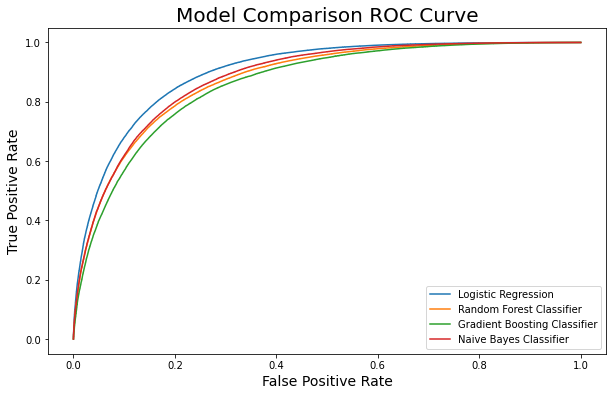

In [85]:
# Valiation ROC Curve

TPRs_log, FPRs_log, thresholds_log = ROC_curve(log_y_half_1_prob, y_half_1_t)

TPRs_rfc, FPRs_rfc, thresholds_rfc = ROC_curve(rfc_y_half_1_prob, y_half_1_t)
TPRs_gbc, FPRs_gbc, thresholds_gbc = ROC_curve(gbc_y_half_1_prob, y_half_1_t)
TPRs_nbc, FPRs_nbc, thresholds_nbc = ROC_curve(nbc_y_half_1_prob, y_half_1_t)


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(FPRs_log, TPRs_log, label='Logistic Regression')
ax.plot(FPRs_rfc, TPRs_rfc, label='Random Forest Classifier')
ax.plot(FPRs_gbc, TPRs_gbc, label='Gradient Boosting Classifier')
ax.plot(FPRs_nbc, TPRs_nbc, label='Naive Bayes Classifier')

ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Model Comparison ROC Curve', fontsize=20)

ax.legend()
#plt.savefig('../img/roc_curve_half.png')
;

### Final Model

#### Logistic Regression

In [0]:
final_log = LogisticRegression(n_jobs=-1, solver='saga')

In [42]:
final_log.fit(tfidf_X_train, final_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# training scores
accuracy_score(final_y_train, final_log.predict(tfidf_X_train)), f1_score(final_y_train, final_log.predict(tfidf_X_train))

(0.8210260237406692, 0.7989546631564723)

In [0]:
log_y_final_prob = final_log.predict_proba(tfidf_X_test)[:,1]
log_y_final_hat = final_log.predict(tfidf_X_test)

In [45]:
# test scores
accuracy_score(final_y_test, log_y_final_hat), f1_score(final_y_test, log_y_final_hat)

(0.8199502471277536, 0.7981046272201077)

In [49]:
roc_auc_score(final_y_test, log_y_final_prob)

0.9021954515669544

#### ROC Curve

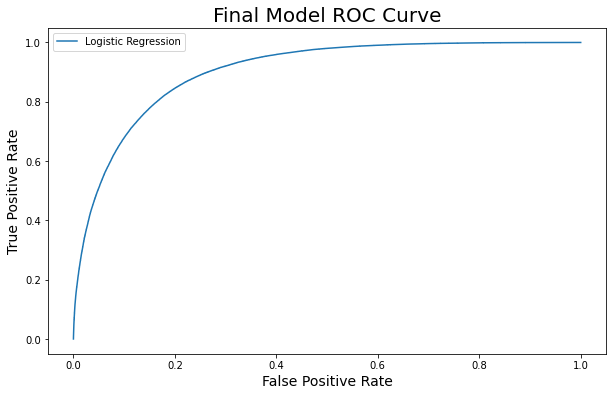

In [48]:
# Final Model ROC

TPRs_final, FPRs_final, thresholds_final = ROC_curve(log_y_final_prob, final_y_test)


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(FPRs_final, TPRs_final, label='Logistic Regression')

ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Final Model ROC Curve', fontsize=20)

ax.legend()
#plt.savefig('../img/roc_curve_final.png')

## Additional Exploratory Data Analysis

In [0]:
# Word Cloud for Reviews

comment_words = '' 
#stopwords = set(STOPWORDS) 
# stopwords = sw
  
# iterate through the csv file 
for val in X_small: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = tokenizer(val) 
      
    comment_words += " ".join(tokens)+" "

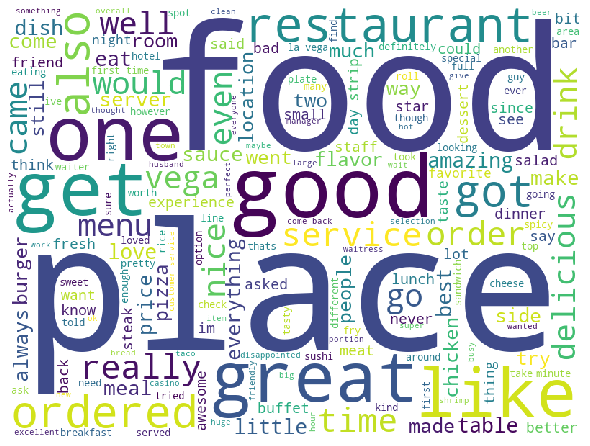

In [0]:
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                stopwords = sw, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()